<a href="https://colab.research.google.com/github/SimoFerri/Parallel-Computing-Challenge/blob/main/PC_Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge 1**

Implement a **batched arbitrarily-size matrix multiplication** kernel.

Let dimensions be identical for all matrix multiplications in the batch.<br>
These being $m, k, n \in \mathbb{N}$.<br>
While $batch \in \mathbb{N}$ is the batch size.

You are provided as input the following matrices:<br>
$N_0, N_1, N_2, ... N_{batch - 1} \in \mathbb{M}^{k \times n}$<br>
$M \in \mathbb{M}^{m \times k}$

You need to compute:<br>
$P_0, P_1, P_2, ... P_{batch - 1} \in \mathbb{M}^{m \times n}$

Where $P_i = M \otimes N_i$ for each $i \in \{0, ..., batch - 1\}$.

---

A baseline reference implementation is given. Implement your version to replace it. Rely on the provided host-side function to check the correctness of results.

To get a general performance metric rely on the profiler, specifically look for the `cuda_gpu_kern_sum` and try to minimize the `Total Time (ns)` of your kernel. Meanwhile, you may also want to improve `cuda_gpu_mem_time_sum`.

Step one is beating the reference implementation, that should be easy, then you can use all tricks in the book to push it further.
Anything goes, but if you use "exotic" tricks we want an explanation.
In fact, submitting your work, be sure to fill out the [report](#report) with brief insights of what you did.

General rules and advice:
- groups are of 3 members at most, that should, for as much as possible, equally contribute to the project.
- you automagically get ~3 points in the 1st part of the exam, taking the form of 1-2 questions that you will be allowed to skip.
- deadline is 1 week (as of this writing, you will need to submit your work before october 23 at 23:59).
- submissions are to be made on WeBeep, where you need to upload a downloaded copy of this notebook (.ipynb file); for groups of multiple people, it's enough for one member to submit the file in the assignment, other members shall simply write their group's name in their submission, we will then infer groups from what you write in the report section.
- your code needs to work here on Colab with the T4 runtime.
- do not alter code sections delimited by "==="s in the final submission.
- we will change around matrix sizes arbitrarily while evaluating your work, so make sure to cover all edge cases and take care that your code is scalable (e.g. execution time grows as expected when doubling all dimensions).
- you can get the maximum grade just by using what was discussed during lectures or is present in the glossary shown during exercise sessions; still, if you wanna have "more fun" this guide is your best friend https://docs.nvidia.com/cuda/cuda-c-best-practices-guide.
- a piece of code that works is better than a supposedly faster piece of code that doesn't, so don't go overboard, but be ambitious.
- use LLMs (ChatGPT and friends) responsibly; the purpose of this challenge is for you to get your hands dirty and build up confidence in writing parallel code through trial and error. Having an LLM write your code may get you the challenge's points (unless it's so blatant that we notice), but won't lead you to learn anything and the next time you see some parallel code your mind goes blank. If you wack your head at the problem instead, and solve it, the solution will stick in the back of your mind for a long time. Similarly, if despite pushing yourself you can't find "that damn bug", then asking an LLM is fine, so long as you tried first by yourself and just say "ahhhhhh, so that what it was!" upon having the LLM help you out. Long story short, AI is fine so long as it's a tool you **learn from** and **not** one you **blindly lean on**.

If you need help or anything, please drop us an email:
- Dr. M. Ronzani: marco.ronzani@polimi.it
- Prof. F. Ferrandi: fabrizio.ferrandi@polimi.it

## **Colab Setup**

In [ ]:
%%capture
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt update
!apt install ./nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt --fix-broken install

In [ ]:
!mkdir /home/cuda
%cd /home/cuda

## **Code**

In [ ]:
%%writefile bmatmul.cpp
// DON'T CHANGE THIS ^^ FILENAME!
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#define TILE_WIDTH 32
#define t 4


// utility for wrapping CUDA API calls and log any error they may return (use this for debugging)
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort = true) {
  if (code != cudaSuccess) {
    fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
    if (abort)
      exit(code);
  }
}

// === DO NOT CHANGE THIS ===
// host-side version, used to validate results
__host__
void batchedMatMulHost(float* M, float* N, float* P, int m, int k, int n, int batch) {
  for (int b = 0; b < batch; b++) {
    for (int row = 0; row < m; row++) {
      for (int col = 0; col < n; col++) {
        float value = 0.0f;
        for (int i = 0; i < k; i++) {
          float a = M[row*k + i];
          float c = N[b*(k*n) + i*n + col];
          value += a * c;
        }
        P[b*(m*n) + row*n + col] = value;
      }
    }
  }
}

void initWith(float number, float* arr, int size) {
  for (int i = 0; i < size; i++)
    arr[i] = number;
}

void initRandom(float* arr, int size, unsigned int seed, float minVal = 0.0f, float maxVal = 1.0f) {
  srand(seed);
  for (int i = 0; i < size; i++) {
    float r = (float)rand() / RAND_MAX;
    arr[i] = minVal + r * (maxVal - minVal);
  }
}

void checkResult(float* arr1, float* arr2, int size) {
  const float atol = 1e-4f; // absolute tolerance for fp32 (lack of) associativity
  const float rtol = 1e-4f; // relative tolerance for fp32 (lack of) associativity
  for (int i = 0; i < size; i++) {
    float diff = fabs(arr1[i] - arr2[i]);
    float tol = atol + rtol*fabs(arr2[i]);
    if (diff > tol) {
      printf("Error at %d: %f != %f (diff=%e, tol=%e)\n", i, arr1[i], arr2[i], diff, tol);
      exit(1);
    }
  }
}
// ==========================

// this is the reference implementation
// you can change this to your heart's contempt
__global__
void batchedMatMul(const float* M, const float* N, float* P, int m, int k, int n, int batch) {
  __shared__ float MTile[TILE_WIDTH*t][TILE_WIDTH];
  __shared__ float NTile[TILE_WIDTH][TILE_WIDTH*t];

  int tx = threadIdx.x; int ty = threadIdx.y;
  int col = (blockIdx.x*TILE_WIDTH + tx)*t;
  int row = (blockIdx.y*TILE_WIDTH + ty)*t;
  int b = blockIdx.z;

  float value[t][t] = {0.0f};

  for (int p = 0; p < (k + TILE_WIDTH - 1)/TILE_WIDTH; ++p) {
    for (int i = 0; i < t; ++i){
      if (row + i < m && p*TILE_WIDTH + tx < k) {
        MTile[t*ty + i][tx] = M[(p*TILE_WIDTH + tx) + (row+i)*k];
      } else {
        MTile[t*ty + i][tx] = 0.0f;
      }

      if (col + i < n && p*TILE_WIDTH + ty < k && b < batch) {
        NTile[ty][t*tx + i] = N[b*(k*n) + (p*TILE_WIDTH + ty)*n + col+i];
      } else {
        NTile[ty][t*tx + i] = 0.0f;
      }
    }
    __syncthreads();

    if (row < m && col < n) {
      #pragma unroll
      for (int i = 0; i < TILE_WIDTH; i++) {
        #pragma unroll
        for (int j = 0; j < t; j++) {
          #pragma unroll
          for (int z = 0; z < t; z++) {
            value[j][z] += MTile[t*ty+j][i]*NTile[i][t*tx+z];
          }
        }
      }
    }
    __syncthreads();
  }
  #pragma unroll
  for (int i = 0; i < t; i++) {
    for (int j = 0; j < t; j++) {
      if (row < m && col < n) {
        P[b*(m*n) + (row+i)*n + col+j] = value[i][j];
      }
    }
  }
}


int main(int argc, char** argv) {
  // === DO NOT CHANGE THIS ===
  if (argc != 6) {
    printf("Usage: %s <m> <k> <n> <batch> <seed>\n", argv[0]);
    exit(1);
  }

  int m = atoi(argv[1]); // rows of Ms and Ps
  int k = atoi(argv[2]); // cols of Ms, rows of Ns
  int n = atoi(argv[3]); // cols of Ns and Ps
  int batch = atoi(argv[4]); // number of matrix pairs
  unsigned int seed = (unsigned int)atoi(argv[5]); // seed for random initialization

  printf("Running batched matmul with m=%d, k=%d, n=%d, batch=%d, seed=%u\n", m, k, n, batch, seed);

  const int sizeM = m*k;
  const int sizeN = k*n*batch;
  const int sizeP = m*n*batch;

  float* M = (float*)malloc(sizeM * sizeof(float));
  float* N = (float*)malloc(sizeN * sizeof(float));
  float* P = (float*)malloc(sizeP * sizeof(float));

  initRandom(M, sizeM, seed);
  initRandom(N, sizeN, seed + 1);
  initWith(0.0f, P, sizeP);
  // ==========================

  // here, you can change anything
  float *M_d;
  float *N_d;
  float *P_d;

  gpuErrchk(cudaMalloc((void**)&M_d, sizeM * sizeof(float)));
  gpuErrchk(cudaMalloc((void**)&N_d, sizeN * sizeof(float)));
  gpuErrchk(cudaMalloc((void**)&P_d, sizeP * sizeof(float)));

  gpuErrchk(cudaMemcpy(M_d, M, sizeM * sizeof(float), cudaMemcpyHostToDevice));
  gpuErrchk(cudaMemcpy(N_d, N, sizeN * sizeof(float), cudaMemcpyHostToDevice));
  gpuErrchk(cudaMemcpy(P_d, P, sizeP * sizeof(float), cudaMemcpyHostToDevice));

  dim3 blockSize(TILE_WIDTH, TILE_WIDTH); // is 16x16 truly the best here?
  dim3 numBlocks((n + blockSize.x*t - 1) / (t*blockSize.x),
                (m + blockSize.y*t - 1) / (t*blockSize.y), batch);

  batchedMatMul<<<numBlocks, blockSize>>>(M_d, N_d, P_d, m, k, n, batch);
  gpuErrchk(cudaDeviceSynchronize());

  gpuErrchk(cudaMemcpy(P, P_d, sizeP * sizeof(float), cudaMemcpyDeviceToHost));

  // === DO NOT CHANGE THIS ===
  // However: once you know results are correct, you can temporarily
  //          comment this out if you want to test performance on large
  //          matrices, since the evaluation on CPU can get pretty slow.
  printf("Checking results on CPU...\n");
  float* P_host = (float*)malloc(sizeP * sizeof(float));
  initWith(0.0f, P_host, sizeP);
  batchedMatMulHost(M, N, P_host, m, k, n, batch);
  checkResult(P, P_host, m*n*batch);
  printf("All results matched, success!");
  // ==========================

  // here, you can change anything, e.g. add some logging
  gpuErrchk(cudaFree(M_d));
  gpuErrchk(cudaFree(N_d));
  gpuErrchk(cudaFree(P_d));

  free(M);
  free(N);
  free(P);
  free(P_host);

  return 0;
}

## **Compile, Run, Profile**

Compile and run:

In [ ]:
!mv bmatmul.cpp bmatmul.cu
!nvcc -arch=sm_75 bmatmul.cu -o bmatmul

In [ ]:
!./bmatmul 256 512 384 16 119

Profile:

In [ ]:
!nsys profile --stats=true ./bmatmul 256 512 384 16 119

<a name="report"></a>
## **Brief Report**

**You must fill in this section!!**

Group information:
- member-1: Emma, Scalvedi, 10806012
- member-2: Paolo, Potì, 11170307
- member-3: Simone, Ferri, 10839956
- CUDA Matata<br>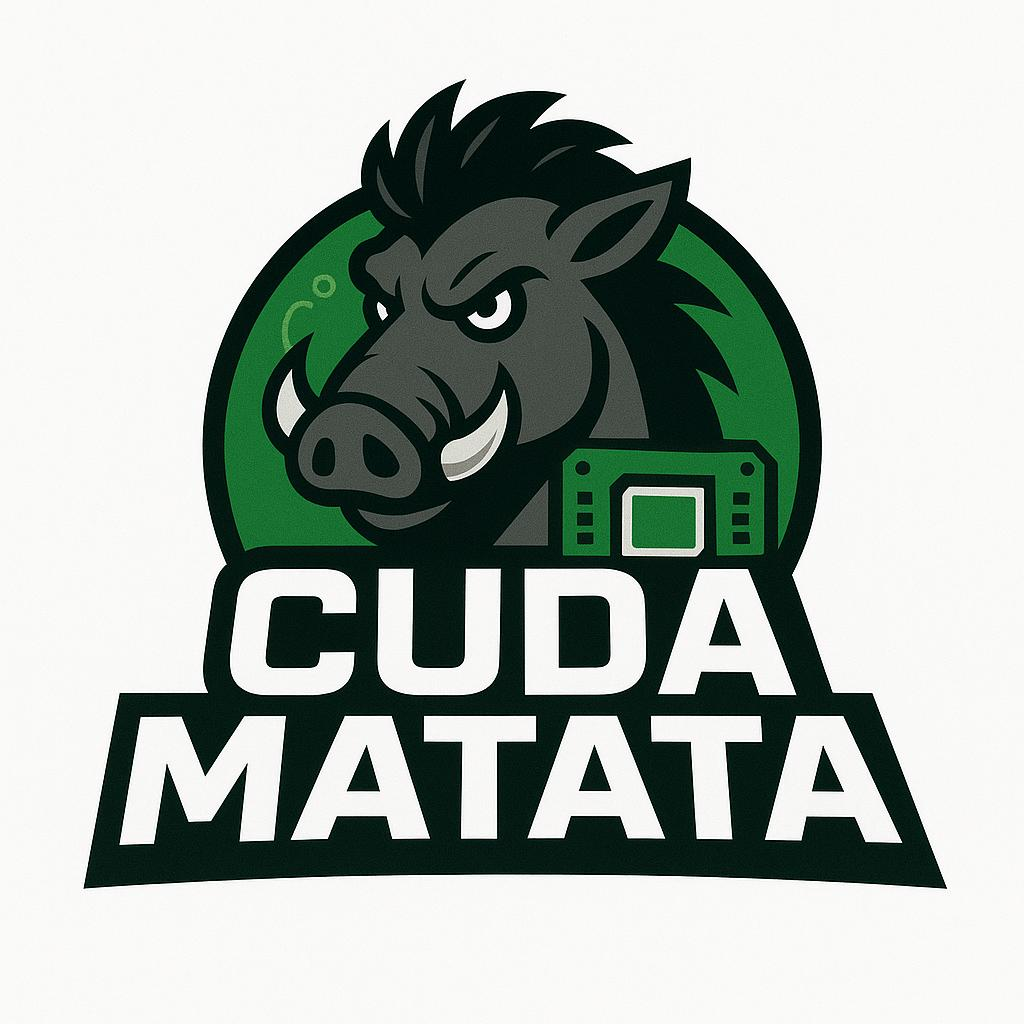

*Note: yes, groups can now have a logo - this is optional and merely for fun, if you don't feel like having one, no worries, in which case you may delete that itemize entry alongside this note :(*
<!-- if you reeeeeally don't have ideas for a logo, before giving up, check this out: https://picrew.me/en/image_maker/47882 -->

What we did and why:
- The single **matrix product is tiled**, making loads from memory collaborative and using shared memory across the threads inside the blocks to reduce the number of memory accesses.
- **Tiles are rectangular**, Mtile(128, 32) and NTile(32, 128). They exploit the data coalescence maximizing the memory bandwith.
- **Thread level tiling**, vectorizing each thread work to let them calculate a (4, 4) tile of P increase arithmetic intensity and data reuse since partial sums of products are stored in local registers.
- **Padding and bounds checking** to make the kernel able to handle matrices of different sizes.
- **Blocks of (32, 32)** so to maximize the occupancy of each SM and to prevent warp divergence.
- Parametric **grid**, rows and columns corresponds to the tiles in which the matrices $P_i$ can be divided while the depth is equals to the batch size, this allows to parallelize products over the batch.
- **#pragma unroll** directive before small loops in order to allow the compiler to make extra optimization.


*Note: possibly less than 8 entries of ~32 words each. More isn't necessarily better if nobody will read it.*

*Note: the subject is "the main things you came up with to improve the kernel".*